# 03: Entangled Deep Dream

In [2]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [3]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import cv2
import numpy as np

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1
import lucent.util as ut

from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL,  PNDMScheduler, UNet2DConditionModel, StableDiffusionPipeline, DiffusionPipeline
from datasets import load_dataset
from functools import lru_cache

from tqdm import tqdm

## Model setup

In [4]:
model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("mps")
pipe.unet.disable_gradient_checkpointing()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


## Test data

In [5]:
dataset = load_dataset("timm/mini-imagenet", split="test")

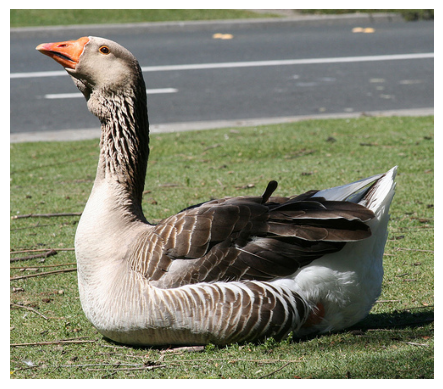

In [6]:
test_img = dataset[300]['image']
np_img = np.array(test_img)
plt.axis('off')
plt.imshow(np_img)

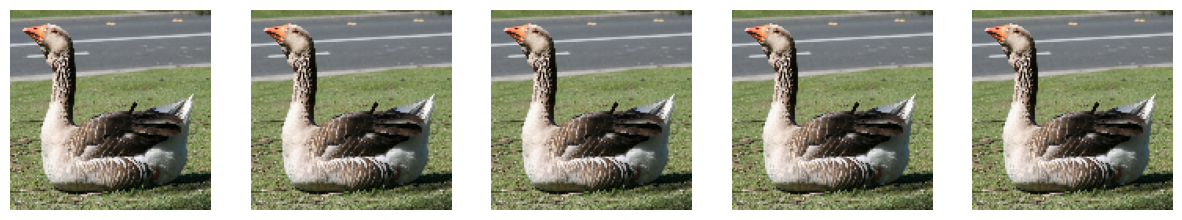

In [7]:
test_images = torch.tensor(np.array([np_img] * 5), device=pipe.device).float().half() # (N, H, W, C)

def to_chw(images: torch.Tensor) -> torch.Tensor:
    return images.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

def to_hwc(images: torch.Tensor) -> torch.Tensor:
    return images.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)

def normalize(tensor: torch.Tensor) -> torch.Tensor:
    max_val = tensor.max()
    min_val = tensor.min()

    if max_val == min_val:
        return torch.zeros_like(tensor)

    norm_0_1 = (tensor - min_val) / (max_val - min_val)

    return norm_0_1 * 2.0 - 1.0

def denormalize(tensor: torch.Tensor) -> torch.Tensor:
    max_val = tensor.max()
    min_val = tensor.min()

    if max_val == min_val:
        return torch.zeros_like(tensor)
    tensor = (tensor - min_val) / (max_val - min_val)

    return tensor * 255.0

test_images = to_chw(test_images)

test_images = torch.nn.functional.interpolate(test_images, size=(128, 128), mode='bilinear')

test_images = normalize(test_images)

def show_images(images: torch.Tensor, size=(15, 15)):
    images = denormalize(images)
    plt.figure(figsize=size)
    for i in range(images.shape[0]):
        img = to_hwc(images)[i].cpu().int().numpy()
        plt.subplot(1, images.shape[0], i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

show_images(test_images)

## Lucent model adapter

In [8]:
class LucentUNetWrapper(nn.Module):
    def __init__(self, pipe: StableDiffusionPipeline, timestep: int, prompt: str = ""):
        super().__init__()
        self.pipe = pipe
        self.unet = pipe.unet
        self.device = pipe.device
        self.dtype = pipe.unet.dtype
        self.prompt = prompt
        self.timestep = timestep
        self.unet.disable_gradient_checkpointing()


    @lru_cache
    def embeddings(self, batch_size: int):
        _, negative_embeds = self.pipe.encode_prompt(
            prompt="",
            device=pipe.device,
            num_images_per_prompt=batch_size,
            do_classifier_free_guidance=True,
            negative_prompt=None
        ) # negative embeds are empty prompt embeddings (None)
        return negative_embeds

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the UNet with the given timestep and prompt embeddings.
        :param z: Latent input tensor of shape (batch_size, channels, height, width)
        :return: Latent output tensor of shape (batch_size, channels, height, width)
        """
        z = z.to(self.device, dtype=self.dtype)

        batch_size = z.shape[0]
        embeddings = self.embeddings(batch_size)

        return self.unet(
            sample=z,
            timestep=self.timestep,
            encoder_hidden_states=embeddings
        ).sample

In [9]:
vae: AutoencoderKL = pipe.vae

def encode_images(images: torch.Tensor) -> torch.Tensor:
    """
    Encode images into latent space using the VAE encoder.
    :param images: Input images tensor of shape (batch_size, channels, height, width)
    :return: Latent representation tensor of shape (batch_size, latent_channels, latent_height, latent_width)
    """
    with torch.no_grad():
        latent_dist = vae.encode(images).latent_dist
        latents = latent_dist.sample()
        latents = latents * vae.config.scaling_factor
    return latents

def decode_latents(latents: torch.Tensor) -> torch.Tensor:
    """
    Decode latent representations back into images using the VAE decoder.
    :param latents: Latent representation tensor of shape (batch_size, latent_channels, latent_height, latent_width)
    :return: Decoded images tensor of shape (batch_size, channels, height, width)
    """
    with torch.no_grad():
        latents = latents / vae.config.scaling_factor
        images = vae.decode(latents).sample
    return images

In [10]:
model = LucentUNetWrapper(pipe, timestep=1).to("mps").eval()
print(test_images.shape)
latent = encode_images(test_images)
print(latent.shape)
latent_noise = model.forward(latent)
print(latent_noise.shape)
noise = decode_latents(latent_noise)
print(noise.shape)

torch.Size([5, 3, 128, 128])
torch.Size([5, 4, 16, 16])
torch.Size([5, 4, 16, 16])
torch.Size([5, 3, 128, 128])


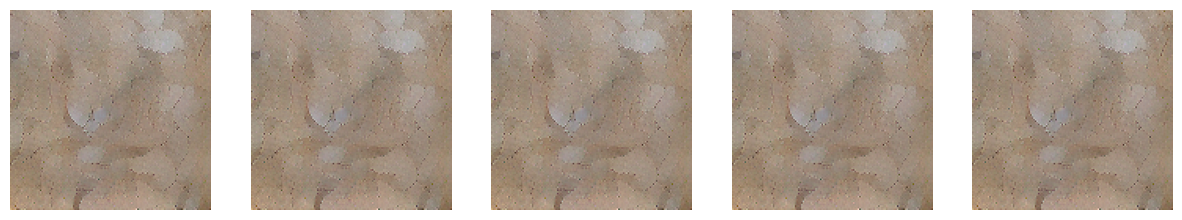

In [11]:
with torch.no_grad():
    show_images(noise)

## Deep Dream sanity check
First we will do a deep dream of a layer in the UNet without any additional noising and SAE

In [12]:
backend_name = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
backend_name

'mps'

In [13]:
device = ut.set_default_device(backend_name)
device

device(type='mps')

In [14]:
pipe.to(device)
model.to(device)

LucentUNetWrapper(
  (unet): UNet2DConditionModel(
    (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=320, out_features=1280, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
    )
    (down_blocks): ModuleList(
      (0): CrossAttnDownBlock2D(
        (attentions): ModuleList(
          (0-1): 2 x Transformer2DModel(
            (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
            (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
            (transformer_blocks): ModuleList(
              (0): BasicTransformerBlock(
                (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                (attn1): Attention(
                  (to_q): Linear(in_features=320, out_features=320, bias=False)
                  (to_k): Linear(in_features=320, out_features=320,

In [15]:
from lucent.modelzoo import util

layers = util.get_model_layers(model)
layers

['unet',
 'unet_conv_in',
 'unet_time_proj',
 'unet_time_embedding',
 'unet_time_embedding_linear_1',
 'unet_time_embedding_act',
 'unet_time_embedding_linear_2',
 'unet_down_blocks',
 'unet_down_blocks_0',
 'unet_down_blocks_0_attentions',
 'unet_down_blocks_0_attentions_0',
 'unet_down_blocks_0_attentions_0_norm',
 'unet_down_blocks_0_attentions_0_proj_in',
 'unet_down_blocks_0_attentions_0_transformer_blocks',
 'unet_down_blocks_0_attentions_0_transformer_blocks_0',
 'unet_down_blocks_0_attentions_0_transformer_blocks_0_norm1',
 'unet_down_blocks_0_attentions_0_transformer_blocks_0_attn1',
 'unet_down_blocks_0_attentions_0_transformer_blocks_0_attn1_to_q',
 'unet_down_blocks_0_attentions_0_transformer_blocks_0_attn1_to_k',
 'unet_down_blocks_0_attentions_0_transformer_blocks_0_attn1_to_v',
 'unet_down_blocks_0_attentions_0_transformer_blocks_0_attn1_to_out',
 'unet_down_blocks_0_attentions_0_transformer_blocks_0_attn1_to_out_0',
 'unet_down_blocks_0_attentions_0_transformer_blocks_0

In [16]:
target = "unet_mid_block_resnets_0_conv2"
# model.unet.up_blocks[1].attentions[1]

In [17]:

# obj = objectives.channel(target, 17)
#
# def param_latents_pixel(w, h=None, batch=1, device=device):
#     h = h or w
#     tensor = torch.randn(batch, 4, h, w).to(device) * 0.01
#
#     tensor.requires_grad_(True)
#
#     return [tensor], lambda: tensor
#
# dream = render.render_vis(
#     model,
#     obj,
#     param_f=lambda: param_latents_pixel(16, device=device),
#     fixed_image_size=16,
#     thresholds=(256,),
#     preprocess=False,
#     transforms=[]
# )

In [18]:
for module in model.unet.named_modules():
    print(module[0])


conv_in
time_proj
time_embedding
time_embedding.linear_1
time_embedding.act
time_embedding.linear_2
down_blocks
down_blocks.0
down_blocks.0.attentions
down_blocks.0.attentions.0
down_blocks.0.attentions.0.norm
down_blocks.0.attentions.0.proj_in
down_blocks.0.attentions.0.transformer_blocks
down_blocks.0.attentions.0.transformer_blocks.0
down_blocks.0.attentions.0.transformer_blocks.0.norm1
down_blocks.0.attentions.0.transformer_blocks.0.attn1
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0
down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.1
down_blocks.0.attentions.0.transformer_blocks.0.norm2
down_blocks.0.attentions.0.transformer_blocks.0.attn2
down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_q
down_blocks.0.attenti

In [29]:
LAYER_NAME = "down_blocks.1.attentions.1.transformer_blocks.0.attn1"
CHANNEL = 10
STEPS = 200
LR = 0.05
LATENT_SIZE = 16
BATCH_SIZE = 5

latents = torch.randn(BATCH_SIZE, 4, LATENT_SIZE, LATENT_SIZE, device=device) * 0.01
latents.requires_grad_(True)

optimizer = torch.optim.Adam([latents], lr=LR)

activations = {}
def get_activation(name):
    def hook(model, input, output):
        # for attention layers
        if isinstance(output, tuple):
            activations[name] = output[0]
        else:
            activations[name] = output
    return hook

target_layer = dict(model.unet.named_modules())[LAYER_NAME]
hook_handle = target_layer.register_forward_hook(get_activation("target"))

print(f"Optimizing Channel {CHANNEL} on {LAYER_NAME}...")


pbar = tqdm(range(STEPS))
try:
    for i in pbar:
        optimizer.zero_grad()

        _ = model(latents)

        act = activations["target"]

        loss = -act[:, CHANNEL].mean()
        loss.backward(retain_graph=True)
        optimizer.step()

        pbar.set_description(f"Loss: {loss.item():.4f}")

except KeyboardInterrupt:
    print("Optimization stopped by user.")
except Exception as e:
    raise e
finally:
    hook_handle.remove()
    print("Hook removed.")

Optimizing Channel 10 on down_blocks.1.attentions.1.transformer_blocks.0.attn1...


Loss: -0.8228: 100%|██████████| 200/200 [00:55<00:00,  3.57it/s]

Hook removed.


Decoding final result...


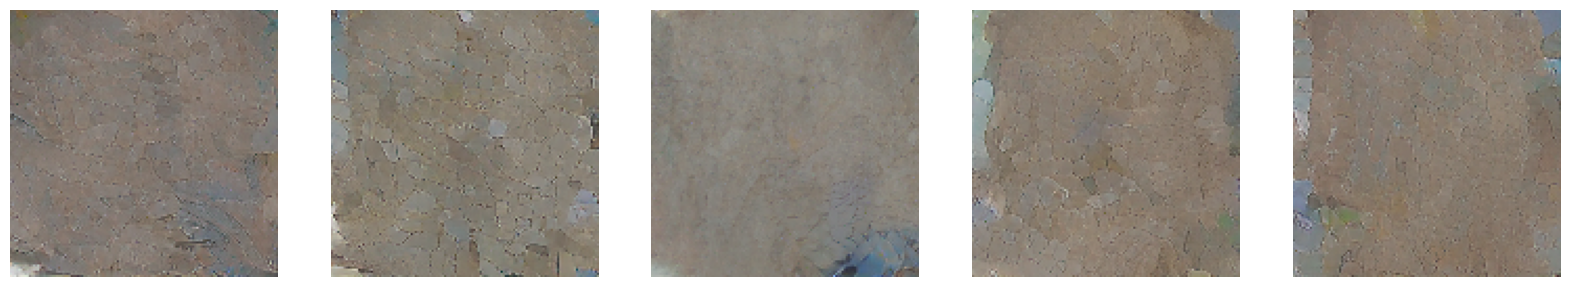

In [30]:
print("Decoding final result...")
final_image = decode_latents(latents.detach().half())
show_images(final_image, size=(20,20))